In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simulate as sim

In [2]:
#starting with an [r,t,n] 
center_of_mass = np.array([[0,0,0]]).T
orbit_radius = 10

sat1_x0 = np.array([[orbit_radius,0,0]]).T #units u
sat1_nx0 = sat1_x0/np.linalg.norm(sat1_x0)
sat1_v = 3 #u/s
sat1_nv0 = np.array([[0,1,1]]).T/np.linalg.norm(np.array([0,1,1]))

sat2_x0 = np.array([[0,orbit_radius,0]]).T #units u
sat2_nx0 = sat2_x0/np.linalg.norm(sat2_x0)
sat2_v = 3 #u/s
sat2_nv0 = np.array([[1,0,1]]).T/np.linalg.norm(np.array([1,0,1]))

sat3_x0 = np.array([[0,0,orbit_radius]]).T #units u
sat3_nx0 = sat3_x0/np.linalg.norm(sat3_x0)
sat3_v = 3 #u/s
sat3_nv0 = np.array([[1,1,0]]).T/np.linalg.norm(np.array([1,1,0]))



del_t = 0.1 #arbitrary time unit
n_orbits = 1
t = np.arange(0,n_orbits*2*np.pi, del_t)

x1 = center_of_mass + orbit_radius * np.sin(t) * sat1_nv0 + orbit_radius * np.cos(t) * sat1_nx0
x2 = center_of_mass + orbit_radius * np.sin(t) * sat2_nv0 + orbit_radius * np.cos(t) * sat2_nx0
x3 = center_of_mass + orbit_radius * np.sin(t) * sat3_nv0 + orbit_radius * np.cos(t) * sat3_nx0



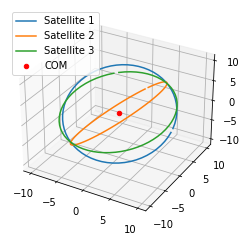

In [3]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(0,0,0,color='r',label="COM")

ax.plot(x1[0,:],x1[1,:],x1[2,:], label='Satellite 1')
ax.plot(x2[0,:],x2[1,:],x2[2,:], label='Satellite 2')
ax.plot(x3[0,:],x3[1,:],x3[2,:], label='Satellite 3')
ax.legend()
#ax.axis("equal")

plt.show()


In [4]:
orbit_radius = 10
sat1_x0 = np.array([[orbit_radius,0,0]]).T #units u
sat1_nv0 = np.array([[0,1,1]]).T/np.linalg.norm(np.array([0,1,1])).T

sat2_x0 = np.array([[0,orbit_radius,0]]).T #units u
sat2_nv0 = np.array([[1,0,1]]).T/np.linalg.norm(np.array([1,0,1])).T

sat3_x0 = np.array([[0,0,orbit_radius]]).T #units u
sat3_nv0 = np.array([[1,1,0]]).T/np.linalg.norm(np.array([1,1,0])).T

# Initialize 3 Observer Satellites
o1 = sim.observer(sat1_x0,sat1_nv0, del_t)
o2 = sim.observer(sat2_x0,sat2_nv0, del_t)
o3 = sim.observer(sat3_x0,sat3_nv0, del_t)

In [5]:
debris_points = np.array([[1,1,1],[1,1,-1],[1,-1,1],[1,-1,-1],[-1,1,1],[-1,1,-1],[-1,-1,1],[-1,-1,-1],[3,0,1],[3,0,-1],[-2,0,-1]]).T
    
    # Initialize the Quaternion for Debris Rotation. 
    # Given any normalized direction vector [nx,ny,nz] and angular rotation [omega], the quaternion is of the 
    # form: [nx*sin(omega/2),ny*sin(omega/2),nz*sin(omega/2),cos(omega/2)]
omega = .01 # rad/s
quat = np.array([0,1*np.sin(omega/2),0,np.cos(omega/2)])

# Initialize the Debris Object
deb = sim.debris(debris_points,quat, del_t)
mtest = sim.MeasurementModel(deb,np.array([o1,o2,o3]),del_t, n_blind=0)

In [6]:
import EKF_class as EKF
n = 36
mu0 = np.zeros((n))
mu0[:3] = np.array([0.0, omega, 0.0])
mu0[3:] = debris_points.T.flatten()
sigma0 = 100* np.diag(np.ones((n)))

kalman_filter = EKF.KalmanFilter(mu0, sigma0, del_t)

In [7]:
sim_time = 1200
t1 = np.linspace(0,sim_time, int(sim_time/del_t))

P_est_hist = np.zeros((len(t1), n, n))
x_est_hist = np.zeros((len(t1), n))
x_est_hist_min = np.zeros((len(t1), n))
for i in range(len(t1)):
    y = mtest[i] #replace with measurements
    sat_pos = o1[i].flatten()


    x_est_min, P_est= kalman_filter.predict()
    x_est, P_est = kalman_filter.update(y[0], x_est_min, P_est, sat_pos)
  
    # Make sure to store the estimated state and covariance for analysis
    P_est_hist[i, :, :] = P_est
    x_est_hist[i, :] = x_est
    x_est_hist_min[i, :] = x_est_min

## Angular Velocity

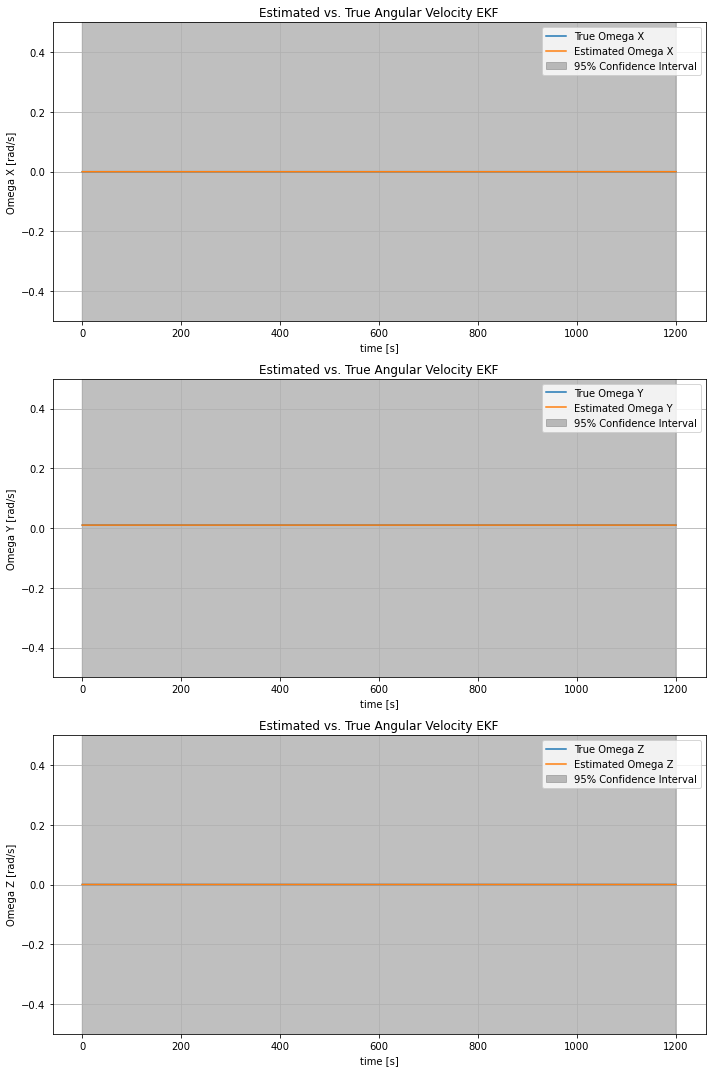

In [8]:
time_step = del_t
time_array = np.arange(0, sim_time, time_step)

std_dev_heading = np.sqrt(P_est_hist[:, 5, 5])
confidence_interval_heading = 1.96 * std_dev_heading #95%

std_dev_x = np.sqrt(P_est_hist[:, 3, 3])
confidence_interval_x = 1.96 * std_dev_x

std_dev_y = np.sqrt(P_est_hist[:, 4, 4])
confidence_interval_y = 1.96 * std_dev_y

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

axs[0].plot(time_array,  np.zeros(len(time_array)), label="True Omega X")
axs[0].plot(time_array, x_est_hist[:, 0], label="Estimated Omega X")
axs[0].fill_between(time_array, x_est_hist[:, 0] - confidence_interval_x, x_est_hist[:, 0] + confidence_interval_x, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('Omega X [rad/s]')
axs[0].legend()
axs[0].grid(True)
axs[0].set_ylim([-0.5, 0.5])
axs[0].set_title('Estimated vs. True Angular Velocity EKF')

# Plot Y Position
axs[1].plot(time_array, omega * np.ones(len(time_array)), label="True Omega Y")
axs[1].plot(time_array, x_est_hist_min[:, 1], label="Estimated Omega Y")
axs[1].fill_between(time_array,  x_est_hist[:, 1] - confidence_interval_y, x_est_hist[:, 1] + confidence_interval_y, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('Omega Y [rad/s]')
axs[1].legend()
axs[1].grid(True)
axs[1].set_ylim([-0.5, 0.5])
axs[1].set_title('Estimated vs. True Angular Velocity EKF')

axs[2].plot(time_array,  np.zeros(len(time_array)), label="True Omega Z")
axs[2].plot(time_array, x_est_hist[:, 2], label="Estimated Omega Z")
axs[2].fill_between(time_array, x_est_hist[:, 2] - confidence_interval_heading, x_est_hist[:, 2] + confidence_interval_heading, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[2].set_xlabel('time [s]')
axs[2].set_ylabel('Omega Z [rad/s]')
axs[2].legend()
axs[2].grid(True)
axs[2].set_title('Estimated vs. True Angular Velocity EKF')
axs[2].set_ylim([-0.5, 0.5])

plt.tight_layout()
plt.show()




## Estimate Point 3

In [9]:
posehist = np.zeros((3, len(time_array)))

for t in range(len(time_array)):
    debr = deb[t].T.flatten()
    posehist[:, t] = debr[6:9]

posehist = posehist.T
print(posehist[0])

[ 1. -1.  1.]


In [10]:
x_est_hist[0, 11]

0.999

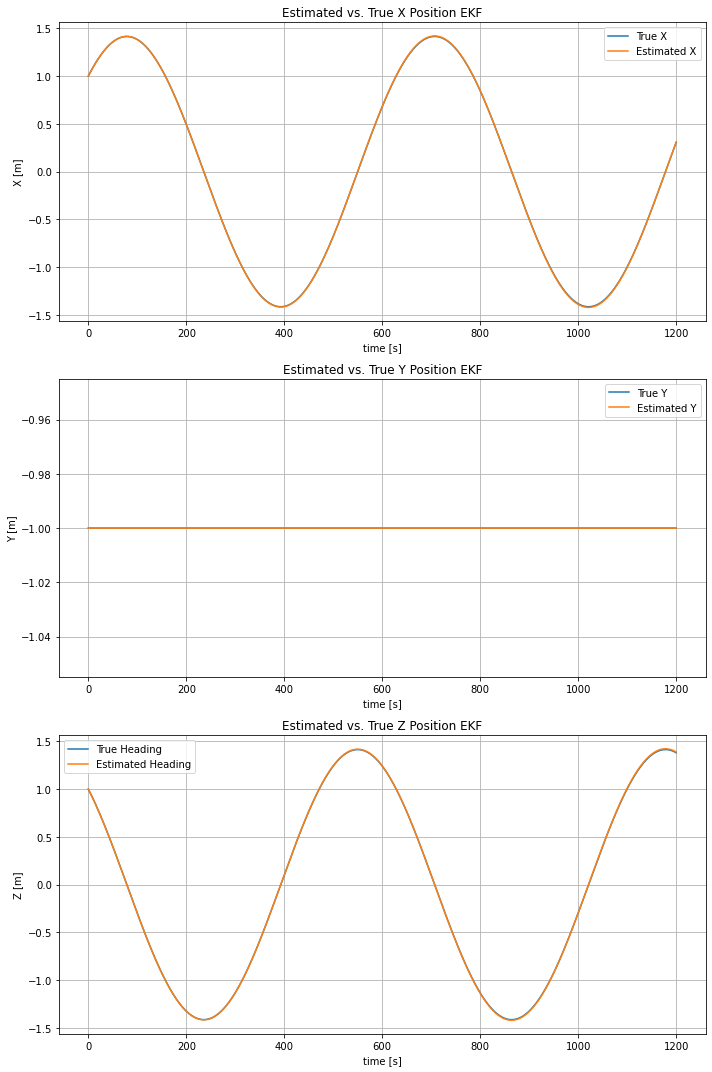

In [12]:
time_step = del_t
time_array = np.arange(0, sim_time, time_step)


std_dev_heading = np.sqrt(P_est_hist[:, 2, 2])
confidence_interval_heading = 1.96 * std_dev_heading #95%

std_dev_x = np.sqrt(P_est_hist[:, 0, 0])
confidence_interval_x = 1.96 * std_dev_x

std_dev_y = np.sqrt(P_est_hist[:, 1, 1])
confidence_interval_y = 1.96 * std_dev_y

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

axs[0].plot(time_array, posehist[:, 0], label="True X")
axs[0].plot(time_array, x_est_hist[:, 9], label="Estimated X")
#axs[0].fill_between(time_array, x_est_hist[:,9] - confidence_interval_x, x_est_hist[:, 9] + confidence_interval_x, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('X [m]')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Estimated vs. True X Position EKF')

# Plot Y Position
axs[1].plot(time_array, posehist[:, 1], label="True Y")
axs[1].plot(time_array, x_est_hist[:, 10], label="Estimated Y")
#axs[1].fill_between(time_array,  x_est_hist[:, 10] - confidence_interval_y, x_est_hist[:, 10] + confidence_interval_y, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('Y [m]')
axs[1].legend()
axs[1].grid(True)
axs[1].set_title('Estimated vs. True Y Position EKF')

axs[2].plot(time_array, posehist[:, 2], label="True Heading")
axs[2].plot(time_array, x_est_hist[:, 11], label="Estimated Heading")
#axs[2].fill_between(time_array, x_est_hist[:, 11] - confidence_interval_heading, x_est_hist[:, 11] + confidence_interval_heading, color='gray', alpha=0.5, label="95% Confidence Interval")
axs[2].set_xlabel('time [s]')
axs[2].set_ylabel('Z [m]')
axs[2].legend()
axs[2].grid(True)
axs[2].set_title('Estimated vs. True Z Position EKF')

plt.tight_layout()
plt.show()


## Plot all Points

## Get Attitude